### 📌 **Note:**  To successfully run this notebook, you should have already executed the corresponding pre-processing notebook! 

### 📝 What happens in the study?
1) Participants answer to the following question: "On average, I send a higher number of words per month than I receive", evaluated on a 7-point-Likert scale (Disagree strongly = 1 ... 'Agree strongly = 7). 
2) Participants see visualizations of how much text they sent and receive (aggregated across all contacts) on average.
3) Participants repeat the subjective assessments in step 1. 

### 📊 What we analyse here
1) Difference between the pre- and post-scores.
2) Statistics of the objective metric: participant dominance index (PDI), defined as total words sent by donor / total words in donor's chats.
3) Correlation of the subjective scores from pre- and post-assessments with the PDI
4) Robustness checks: Do the steps described above using different subsamples and PDI values, e.g. overall PDI, Median Monthly PDI, Last month PDI. 

---

In [1]:
import os
import sys
import warnings
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
sys.path.insert(1, os.path.abspath('../'))
sys.path.insert(1, os.path.abspath('../../..'))

from modules.plots import set_aspect
from modules.utils import save_descriptive_stats,save_variables, significance_asterisk
from modules.config import data_reports_path, figpath, pre_color, post_color, default_color

In [2]:
# Load the quantitative metrics of messaging balance (see preprocessing for the calculation)
data =  pd.read_excel(Path(f'../../data/processed/messaging_dominance_data.xlsx'))

# Define relevant variables for documenting
analysis = 'dominance'
question_code = 'sending_more_words'
quantitative_default = 'Overall PDI'
quantitative_columns = ['Overall PDI','Median PDI','Last Month PDI'] # different metrics used as "objective index"

---
###  Compare the pre- and post-feedback assessment scores - Table 2 (Panel A), Appendix Figure A7 (right)                                                 
The following cell loads the questionnaire responses from the pre- and post-surveys, plots the scores and the post-pre difference as histograms. In addition, a Wilcoxon paired-test is calculated to see if the responses change between the two assessments! 

dominance-Wilcoxon_Stat  378
dominance-Wilcoxon_p       0.486
dominance-Wilcoxon_Z      -0.68
dominance-ES               0.086
dominance-Zero_Diff       34.921
dominance-Non-Zero_Diff   65.079
dominance-pre-Mean         2.889
dominance-post-Mean        3.111
dominance-diff-Mean        0.222
dominance-pre-Median       3
dominance-post-Median      3
dominance-diff-Median      0
dominance-pre-Std          1.357
dominance-post-Std         1.686
dominance-diff-Std         1.68
dominance-pre-Min          1
dominance-post-Min         1
dominance-diff-Min        -3
dominance-pre-Max          6
dominance-post-Max         7
dominance-diff-Max         6


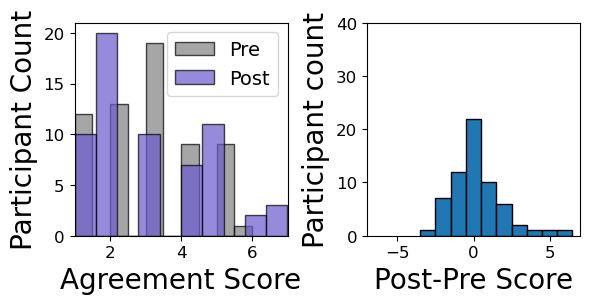

In [3]:
from modules.plots import plot_score_diff_hist
from modules.tests import calculate_wilcoxon,summarize_score_comparison
pre_scores = data[f'{question_code}_pre']
post_scores = data[f'{question_code}_post']
plot_score_diff_hist(data,question_code,analysis)

# Statistical analysis with Wilcoxon test 
W, p_value, Z, effect_size = calculate_wilcoxon(pre_scores,post_scores)
summarize_score_comparison(analysis, question_code, data, W, p_value, Z, effect_size,display=True)

save_variables(data_reports_path,f'{analysis}-Wilcoxon-N',len(post_scores))


---
### Summarize information about the quantitative metric PDI (e.g. median, mean, etc) and flag the outliers!

In [4]:
save_descriptive_stats(data_reports_path,f'{analysis}-{quantitative_default}',data[quantitative_default])

# Flag the outliers of the PDI using the Interquartile Range (IQR) method
from modules.utils import get_outlier_bounds
lower_bound,upper_bound = get_outlier_bounds(data[{quantitative_default}])
data[f'{quantitative_default}-outlier'] = ((data[{quantitative_default}] < lower_bound) | (data[{quantitative_default}] > upper_bound)).astype(int)

---
### Calculate the correlations between subjective scores and the quantitative metric - Table 2 (Panel B) 
For the calculation of the correlations, the outliers are not included. However, they are visualized for transparency. 

In [5]:
from modules.tests import summarize_spearman_results,compare_correlations_zou, compare_correlations_steiger
from scipy.stats import spearmanr
from modules.plots import plot_corr_raw

# Data without the outliers
correlation_data = data[data[f'{quantitative_default}-outlier'] == 0]
sample_size = len(correlation_data)

# Mark the outliers for visualization
outlier_data = data[data[f'{quantitative_default}-outlier'] == 1]

save_variables(data_reports_path,f'{analysis}-non-outlier-N',len(correlation_data))
save_variables(data_reports_path,f'{analysis}-outlier-N',len(outlier_data))

# Quick check that counts add up to total
total_check = len(outlier_data) + len(correlation_data)
if total_check != len(data):
    raise ValueError(
        f"Outlier/non-outlier counts ({total_check}) do not add up to total data length ({len(data)}). "
        f"Possible missing or invalid values in '{quantitative_default}-outlier'.")

# Calculate the spearman correlations
results = {"pre_spearman": spearmanr(correlation_data[f'{question_code}_pre'], correlation_data[quantitative_default]),
        "post_spearman": spearmanr(correlation_data[f'{question_code}_post'], correlation_data[quantitative_default]),
        "diff_spearman": spearmanr(correlation_data[f'{question_code}_diff'], correlation_data[quantitative_default]),
        "pre_post_r": spearmanr(correlation_data[f'{question_code}_pre'].tolist(), correlation_data[f'{question_code}_post'].tolist())}

# This part of the code compares the correlation(pre-score,objective metric) with correlation(post-score, objecive metric) using two approaches

# Zou confidence interval approach
lower_zou, upper_zou = compare_correlations_zou(results["pre_spearman"][0], results["post_spearman"][0], results["pre_post_r"][0], sample_size)

# Steiger's test using two-tailed and one-tailed comparisons
t_steiger2,p_steiger2 = compare_correlations_steiger(results["pre_spearman"][0], results["post_spearman"][0], results["pre_post_r"][0], sample_size,twotailed=True)
t_steiger1,p_steiger1= compare_correlations_steiger(results["pre_spearman"][0], results["post_spearman"][0], results["pre_post_r"][0], sample_size,twotailed=False)

# Summarize the results
summarize_spearman_results(analysis, quantitative_default, results, lower_zou, upper_zou,t_steiger2,p_steiger2,t_steiger1,p_steiger1)

+----+---------------------------------------+----------+
|    | Metric                                | Value    |
+====+=======================================+==========+
|  0 | dominance-pre-Overall PDI-spearman-r  | 0.09     |
+----+---------------------------------------+----------+
|  1 | dominance-pre-Overall PDI-spearman-p  | 0.510    |
+----+---------------------------------------+----------+
|  2 | dominance-post-Overall PDI-spearman-r | 0.41     |
+----+---------------------------------------+----------+
|  3 | dominance-post-Overall PDI-spearman-p | 0.0014** |
+----+---------------------------------------+----------+
|  4 | dominance-diff-Overall PDI-spearman-r | 0.34     |
+----+---------------------------------------+----------+
|  5 | dominance-diff-Overall PDI-spearman-p | 0.0092** |
+----+---------------------------------------+----------+
|  6 | dominance-Overall PDI-zou-upper       | -0.05    |
+----+---------------------------------------+----------+
|  7 | dominan

---
### Fig.3A - Plot the subjective scores and quantitative scores on the same plot. 
The numbers in each cell show the median value of the quantitative metric across the participants falling in that response cell. 

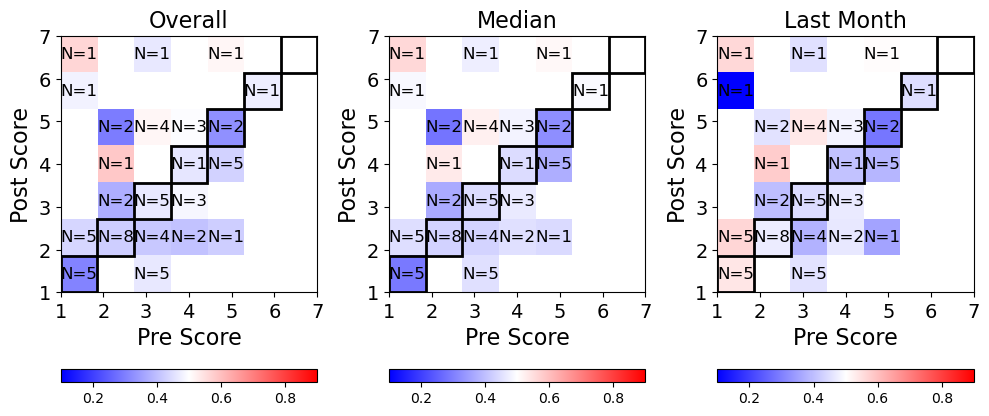

In [6]:
from modules.plots import plot_heatmap
plot_heatmap(data, question_code,quantitative_columns, analysis)

---
### Figure 3B: Plot the correlations between the objective metric and the subjective scores (for given subsamples).


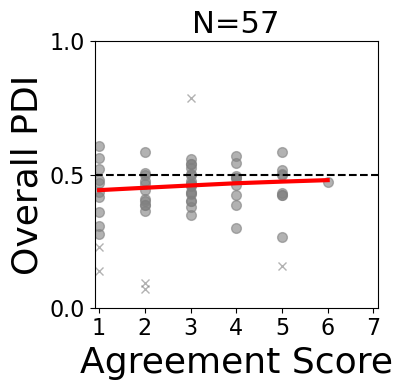

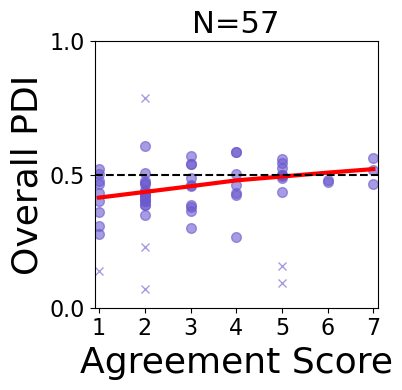

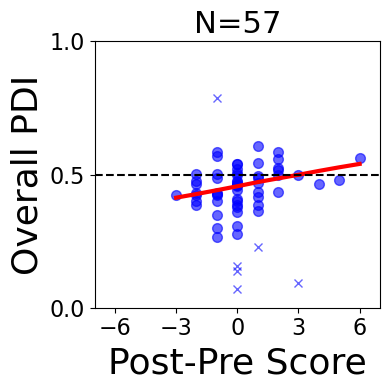

In [7]:
question_clode = 'Overall PDI'
sample_data = data
subsample = 'all'

correlation_data = sample_data[sample_data[f'{quantitative_default}-outlier'] == 0]
outlier_data = sample_data[sample_data[f'{quantitative_default}-outlier'] == 1]

from modules.plots import plot_corr_raw
plot_corr_raw(correlation_data,outlier_data,question_code,'pre',analysis,quantitative_default,color=pre_color,label=subsample,ylim=[0,1])
plot_corr_raw(correlation_data,outlier_data,question_code,'post',analysis,quantitative_default,color=post_color,label=subsample,ylim=[0,1])
plot_corr_raw(correlation_data,outlier_data,question_code,'diff',analysis,quantitative_default,color=default_color,label=subsample,ylim=[0,1])

---
### Figure A8 (Messaging dominance) - Check if there are any subsample effects or recency effects. 

The recency effect is checked by correlating the quantitative metric calculated based on the last donation month with the subjective scores. If the pre-post change was statistically significant, an asterisk is added on top of the result. Otherwise, the larger size of the dots indicates significance for the pre (gray) and post (purple) correlations. 

####  ⏳ **Note:** This step will take a while as for each correlation, a bootstrapping method is used to evaluate the confidence intervals!  

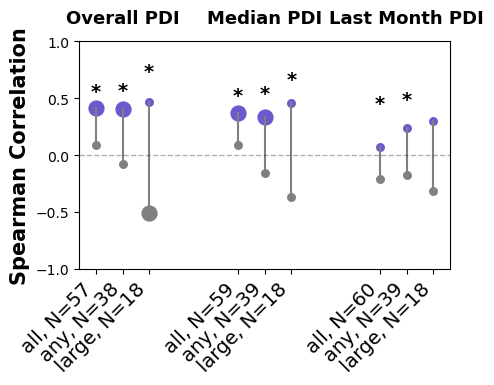

In [8]:
# Define subsets based on response differences
from modules.plots import plot_corr_differences
plot_corr_differences(data,question_code,quantitative_columns,analysis)